# Global Model-Agnostic Methods

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 02/06/2025   | Martin | Created   | Notebook created. Started Partial Dependence Plot (PDP) | 
| 04/06/2025   | Martin | Update   | Started permutation importance | 
| 17/06/2025   | Martin | Update   | Added Prototypes and Criticisms | 

# Content

* [Introduction](#introduction)

# Partial Dependence Plot (PDP)

Partial Dependence Plot (PDP) shows the marginal effect one or two features have on the predicted outcome. It describes the average marginal change based on the changes to a set of features. Holding the feature in question constant, the model is predicted across all other data instances and the results are averaged

In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from alibi.explainers import PartialDependence, plot_pd
from alibi.explainers import PermutationImportance, plot_permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [14]:
bike = pd.read_csv("data/bike_rental/day_cleaned.csv")

# Select columns
cols = [
  'holiday',
  'season',
  'weather_rmp',
  'workingday',
  'cnt_2d_bfr',
  'rel_hum',
  'temp_cel',
  'windspeed_kmh',
  'cnt'
]
bike = bike[cols]

# Specify categorical columns
cat_cols = ['holiday', 'season', 'weather_rmp', 'workingday']
for col in cat_cols:
  bike[col] = bike[col].astype('category')

bike.head()

,holiday,season,weather_rmp,workingday,cnt_2d_bfr,rel_hum,temp_cel,windspeed_kmh,cnt
0,0,1,1,1,985,43.7273,8.050924,16.636703,1349
1,0,1,1,1,801,59.0435,8.200000,10.739832,1562
2,0,1,1,1,1349,43.6957,9.305237,12.522300,1600
3,0,1,1,1,1562,51.8261,8.378268,6.000868,1606
4,0,1,2,1,1600,49.8696,8.057402,11.304642,1510


In [6]:
# Split data
y = bike['cnt']
X = bike.drop('cnt', axis=1)

# dtrain = xgb.DMatrix(X, y, enable_categorical=True)

In [ ]:
# Train xgboost regressor model
# params = {
#   'objective': 'reg:squarederror',
#   'tree_method': 'hist',
#   'max_depth': 3,
#   'learning_rate': 0.1,
#   'verbosity': 2
# }

model = xgb.XGBRegressor(
  tree_method='hist',
  max_depth=3,
  learning_rate=0.1,
  verbosity=2
)
model.fit(X, y)

[18:46:06] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (728, 8, 5824).


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
# Partial dependence explainer
part_d = PartialDependence(
  predictor=model.predict,
  feature_names=list(X.columns),
  categorical_names=cat_cols,
  target_names=['cnt']
)

exp = part_d.explain(
  X=X.to_numpy(),
  kind='average'
)

array([[<Axes: xlabel='holiday', ylabel='cnt'>,
        <Axes: xlabel='season', ylabel='cnt'>,
        <Axes: xlabel='weather_rmp', ylabel='cnt'>],
       [<Axes: xlabel='workingday', ylabel='cnt'>,
        <Axes: xlabel='cnt_2d_bfr', ylabel='cnt'>,
        <Axes: xlabel='rel_hum', ylabel='cnt'>],
       [<Axes: xlabel='temp_cel', ylabel='cnt'>,
        <Axes: xlabel='windspeed_kmh', ylabel='cnt'>, None]], dtype=object)

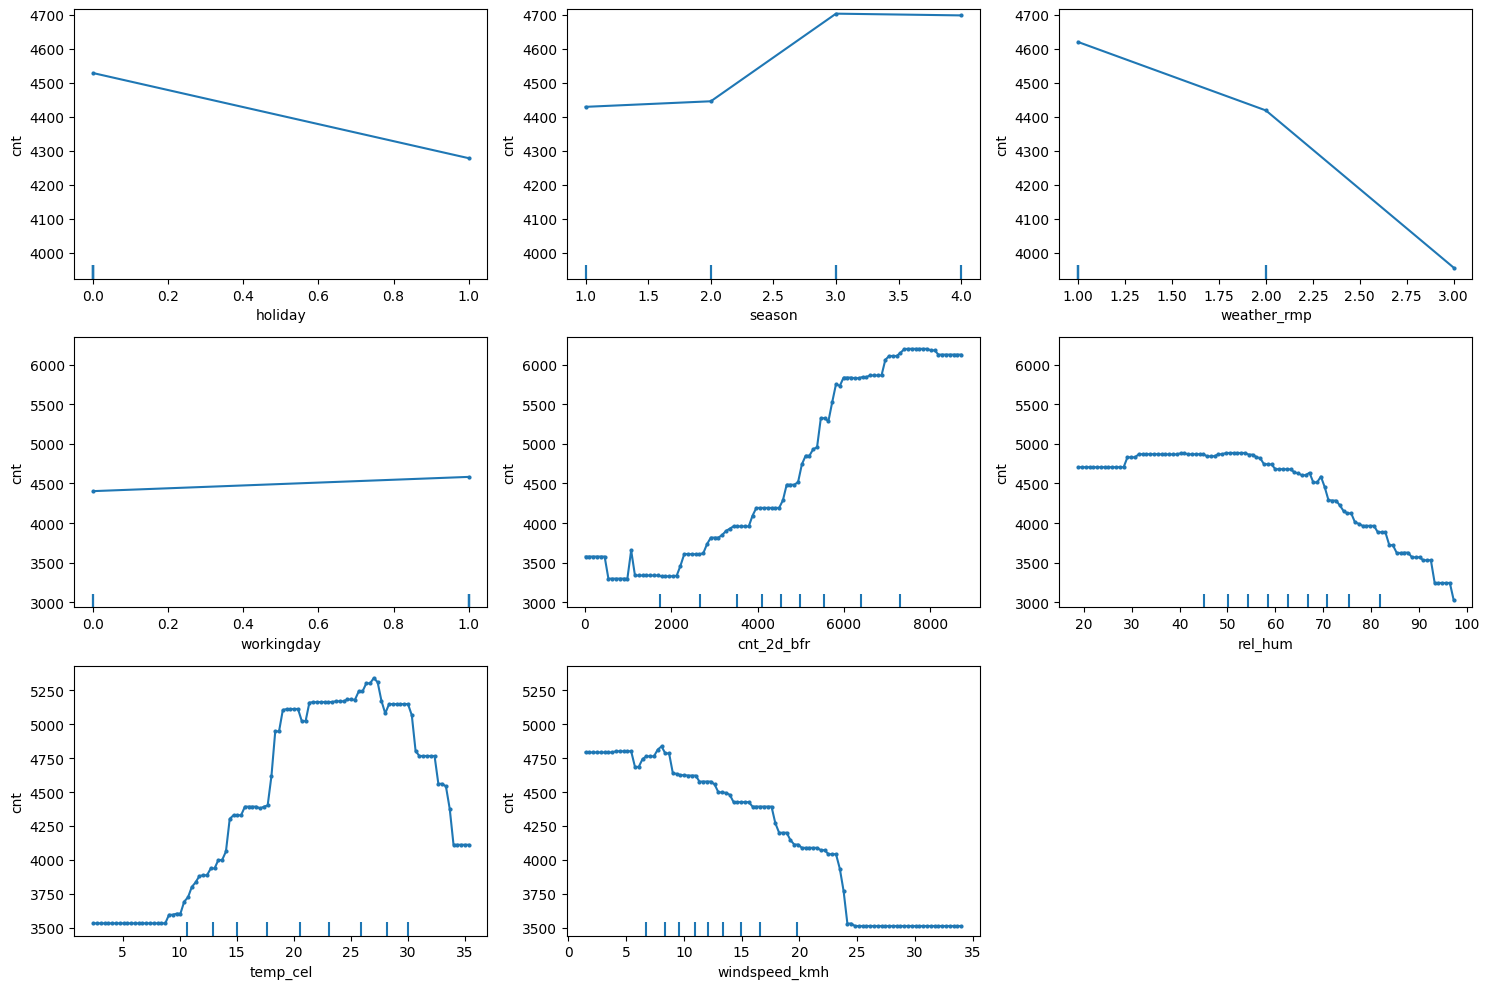

In [ ]:
plot_pd(
  exp=exp,
  n_cols=3,
  sharey='row',
  fig_kw={'figheight': 10, 'figwidth': 15}
)

---

# Permutation Importance

TODO: Add Description

Performing on bike dataset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Train the model
model = SVR()
model.fit(X_train.to_numpy(), y_train.to_numpy())

SVR()

In [38]:
pfi = PermutationImportance(
  predictor=model.predict,
  loss_fns='mean_squared_error',
  feature_names=list(X.columns)
)
exp = pfi.explain(X=X_test.to_numpy(), y=y_test.to_numpy())

array([[<Axes: title={'center': 'mean_squared_error'}, xlabel='Permutation feature importance'>]],
      dtype=object)

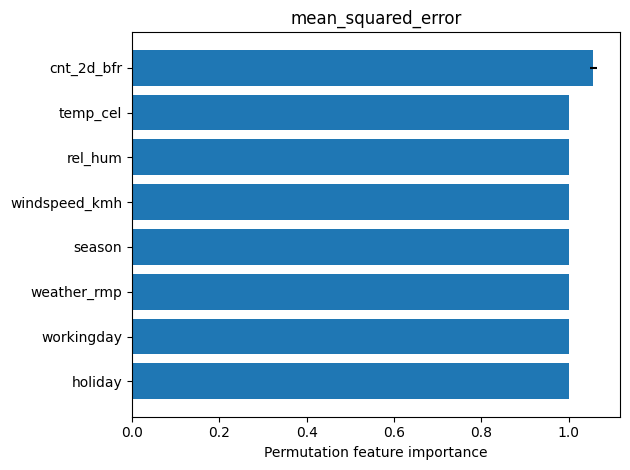

In [39]:
plot_permutation_importance(exp)

## Group-wise permutation importance

TODO: Add description

---

# Prototypes & Criticisms

Generate __Prototypes__ and __Criticisms__ points that explain the data distribution.

- Protoypes - Central points that selected represent the data distribution
- Criticisms - Points that are not well represented by the prototype distribution (similar to outliers)

Method gives a better understanding of: (1) Data distribution (2) Can be used as a classification model (3) Make black-box models interpretable

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from mmd_critic import MMDCritic
from mmd_critic.kernels import RBFKernel

In [2]:
df = pl.read_csv('./data/penguins/penguins_cleaned.csv')
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f64,f64,f64,f64,str
"""Adelie""","""Torgersen""",39.1,18.7,181.0,3750.0,"""MALE"""
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE"""
"""Adelie""","""Torgersen""",40.3,18.0,195.0,3250.0,"""FEMALE"""
"""Adelie""","""Torgersen""",36.7,19.3,193.0,3450.0,"""FEMALE"""
"""Adelie""","""Torgersen""",39.3,20.6,190.0,3650.0,"""MALE"""


In [10]:
NUM_PROTOS = 5
NUM_CRITICS = 5

In [31]:
# Only use 2 variables so that features are plottable
X = df.select(['culmen_length_mm', 'culmen_depth_mm'])
y = [1 if i == "MALE" else 0 for i in df['sex']]

# Setup the mmd_critic
critic = MMDCritic(
  X,
  prototype_kernel=RBFKernel(sigma=1),
  criticism_kernel=RBFKernel(sigma=2),
  labels=y
)

# Select prototypes, criticisms and labels
protos, proto_labels = critic.select_prototypes(NUM_PROTOS)
critics, critics_labels = critic.select_criticisms(NUM_CRITICS, protos)

# Create prototype and criticisms Dataframe
df_mmd = pl.DataFrame(
  np.concatenate((protos, critics)),
  schema=['culmen_length_mm', 'culmen_depth_mm']
)
df_mmd = df_mmd.with_columns(
  pl.Series([1] * len(protos) + [0] * len(critics)).alias("label")
)
df_mmd

culmen_length_mm,culmen_depth_mm,label
f64,f64,i64
39.6,18.1,1
46.5,14.8,1
49.4,15.8,1
36.6,17.8,1
50.8,19.0,1
50.5,18.4,0
50.1,17.9,0
50.8,18.5,0
50.2,18.7,0


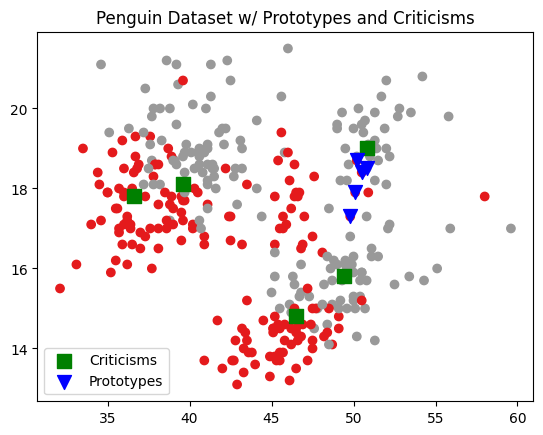

In [51]:
df_protos = df_mmd.filter(pl.col('label') == 1)
df_critics = df_mmd.filter(pl.col('label') == 0)

plt.scatter(X['culmen_length_mm'], X['culmen_depth_mm'], c=y, cmap='Set1')
plt.scatter(df_protos['culmen_length_mm'], df_protos['culmen_depth_mm'], c="g", s=100, marker="s", label='Criticisms')
plt.scatter(df_critics['culmen_length_mm'], df_critics['culmen_depth_mm'], c="b", s=100, marker="v", label='Prototypes')
plt.title("Penguin Dataset w/ Prototypes and Criticisms")
plt.legend()
plt.show()